In [6]:
#import necessary libraries and Modules

from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import matplotlib.pyplot as plt
import ImageManipFuncs as IMF
import PlottingFuncs as PF
import ImageAnalysis as IA
import myGUI 
import importlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import math
from PIL import Image, ImageDraw, ImageTk, ImageOps
import tkinter as tk
from tkinter import ttk
from astropy.io import fits
from skimage.morphology import skeletonize
from skimage import io
import csv
import Metric
from scipy.ndimage import minimum_filter, maximum_filter
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats
import copy 
import subprocess
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from matplotlib.colors import ListedColormap

In [7]:
def local_min_max_normalization(image, window_size):
    """
    Perform local min/max normalization on an image using a sliding window.

    Parameters:
    - image: 2D numpy array representing the grayscale image to be normalized.
    - window_size: Size of the sliding window (must be an odd integer).

    Returns:
    - normalized_image: 2D numpy array with local min/max normalized values.
    """
    # Check that window_size is odd
    if window_size % 2 == 0:
        raise ValueError("window_size must be an odd integer.")

    # Ensure the image is in float format for precision
    image = image.astype(np.float64)

    # Compute the local min and max using minimum_filter and maximum_filter
    local_min = minimum_filter(image, size=window_size, mode='reflect')
    local_max = maximum_filter(image, size=window_size, mode='reflect')

    # Perform local min/max normalization
    # Avoid division by zero by adding a small epsilon to the denominator
    epsilon = 1e-10
    normalized_image = (image - local_min) / (local_max - local_min + epsilon)

    # Clip values to the range [0, 1]
    normalized_image = np.clip(normalized_image, 0, 1)

    return normalized_image

import numpy as np
from skimage.util import view_as_windows

import numpy as np
from skimage.util import view_as_windows

def divide_by_local_std(image, window_size):
    """
    Slides a rectangle (local window) over an image and divides the values in the window 
    by the standard deviation of that window.
    
    Parameters:
    - image: 2D NumPy array (grayscale image)
    - window_size: size of the local rectangle (tuple: (window_height, window_width))
    
    Returns:
    - output_image: 2D NumPy array where each local window is divided by its standard deviation
    """
    # Get sliding windows for local regions
    # Initialize the output array
    output_image = np.zeros_like(image, dtype=float)

    # Get the dimensions of the image
    image_height, image_width = image.shape
    window_height, window_width = window_size

    # Iterate over each pixel in the image, ensuring we stay within bounds for the window
    for i in range(0, image_height - window_height + 1, window_height):
        for j in range(0, image_width - window_width + 1, window_width):
        # Extract the current window (local region)
            local_region = image[i:i + window_height, j:j + window_width]
            
            # Compute standard deviation of the window
            std = np.std(local_region)
            
            # Prevent division by zero
            if std == 0 or std == np.nan:
                std = 1
            print(std)
            output_image[i:i + window_height, j:j + window_width] = local_region/std

    return output_image

# Example usage:
# image = np.random.rand(100, 100)  # Random image for demonstration
# result = divide_by_local_std(image, (5, 5))  # Sliding a 5x5 rectangle over the image


In [15]:

# Specify the path to your FITS file
fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\galaxysim_SigmaHI_scaledecomposed_intensitytransformed\galaxysim_SigmaHI_CDDss0016pc_arcsinh0p1.fits"

# Load the FITS file data
hdul = fits.open(fits_file)
image_data = np.array(hdul[0].data)  # Assuming the image data is in the primary HDU

#subtract background
data = image_data.astype(np.float64)
# Background subtraction
bkg_estimator = MedianBackground()
size = 16
bkg = Background2D(data, (size,size), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background
print(f'min after bkg sub: {np.min(data)}')

#bkg sub map
topval=np.nanpercentile(data[data!=0],99.999)
datascl=data*65535/topval

input_image = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\GalaxySimScl_16bit16pc.png"

#account for neg values
# datascl[datascl < 0 ] = 0
datascl = datascl.astype(np.uint16)

cv2.imwrite(input_image, (datascl.astype(np.uint16)))

meanval,medianval,stddevval= sigma_clipped_stats(datascl[datascl!=0],sigma=3,maxiters=None)

print(medianval,stddevval)

data[data<0] = 0
fits_file_path =  fr'C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\GalaxySim16pc.fits'
fits.writeto(fits_file_path, (data), overwrite=True)


min after bkg sub: -0.4152080795734249
50507.0 25808.692854560788


In [9]:
input_image = input_image #taken from above

batch = r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe"
# param_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\Parameter_files"
param_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params"

for param_file in os.listdir(param_dir):
    # Use numpy.arange() to generate floating-point values
    # Split the file name into base name and extension
    base_name, extension = os.path.splitext(param_file)

    # Print the base name without extension
    # output_dir = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\results\{base_name}"
    output_dir = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\{base_name}"

    assert(os.path.isdir(output_dir))
    # parameter_file = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\Parameter_files\{param_file}"
    parameter_file = fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\{param_file}"

    assert( os.path.isfile(parameter_file))
    assert( os.path.isfile(input_image))

    cmdString = f'"{batch}" soax -i "{input_image}" -p "{parameter_file}" -s "{output_dir}" --ridge 0.005 0.01 0.04 --stretch 3.0 0.5 4.0'
    print("starting SOAX")
    subprocess.run(cmdString, shell=True)  # Use shell=True if command needs shell features
    print(f'{param_file} complete')


AssertionError: 

In [2]:
import subprocess
import pandas as pd 

result_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results"
# Define the expected header line for identification
expected_header = "s p x y z fg_int bg_int"

for result_folder in os.listdir(result_dir):
    result_folder = os.path.join(result_dir, result_folder)
    for result_file in os.listdir(result_folder):
        if(result_file.endswith('.txt')):
            input_file_path = os.path.join(result_folder, result_file)
            print(f' wprking on {input_file_path}')
            assert( os.path.isfile(input_file_path))
            
            base_name, extension = os.path.splitext(input_file_path)
            output_file_path = output_dir = fr'{result_folder}\{result_file}To_csv.csv'

            # Read the content of the input file
            with open(input_file_path, 'r') as file:
                lines = file.readlines()

            # Find the index where the header starts
            header_start_index = None
            for i, line in enumerate(lines):
                # Normalize line by stripping extra spaces
                normalized_line = ' '.join(line.split())

                if normalized_line == expected_header:
                    header_start_index = i
                if "[" in line:
                    stopper_index = i
                    break

            if header_start_index is None:
                print('HEADER NOT FOUND!')
                continue

            # Extract header and data
            header_and_data = lines[header_start_index:stopper_index]

            # Write to CSV
            with open(output_file_path, 'w', newline='') as csvfile:
                csv_writer = csv.writer(csvfile)
                
                for line in header_and_data:
                    # Split columns by whitespace (assuming whitespace is the delimiter)
                    row = line.split()
                    csv_writer.writerow(row)

            print(f"{result_file} has been saved to {output_file_path}")

            df = pd.read_csv(output_file_path)
            # Convert coordinates to float
            x_coords = df["x"].astype(float)
            y_coords = df["y"].astype(float)

            # Filter out NaN values and convert to integers
            x_coords_cleaned = [int(round(x)) for x in x_coords if not pd.isna(x)]
            y_coords_cleaned = [int(round(y)) for y in y_coords if not pd.isna(y)]
            assert(len(x_coords_cleaned)==len(y_coords_cleaned))
            coordinates = list(zip(x_coords_cleaned,y_coords_cleaned))


            gray_image = np.zeros_like(image_data)
            # Step 3: Color the coordinates purple
            # Ensure coordinates are within the image bounds
            for (y,x) in coordinates:
                if 0 <= x < gray_image.shape[0] and 0 <= y < gray_image.shape[1]:
                    gray_image[x, y] = 1

            
            fits_file_path = output_dir = fr'{result_folder}\{result_file}To_fits.fits'

            fits.writeto(fits_file_path, gray_image, overwrite=True)
            print(f'fits saved to {fits_file_path}')

 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch2.500.txt
ThresholdedImage--ridge0.005000--stretch2.500.txt has been saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch2.500.txtTo_csv.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_50228\1145482826.py:53: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file_path)


fits saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch2.500.txtTo_fits.fits
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch3.000.txt
ThresholdedImage--ridge0.005000--stretch3.000.txt has been saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch3.000.txtTo_csv.csv
fits saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.005000--stretch3.000.txtTo_fits.fits
 wprking on C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.01500--stretch2.500.txt
ThresholdedImage--ridge0.01500--stretch2.500.txt has been saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1\ThresholdedImage--ridge0.01500--

NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\HP\\Documents\\JHU_Academics\\Research\\SOAX_results\\best_results\\best_param1.fits'

In [4]:
import numpy as np
import os
from astropy.io import fits

def process_fits_files(directory, N):
    # List to hold the data from each FITS file
    fits_data_list = []

    # Loop through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.fits'):
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            
            # Open the FITS file and read the data
            with fits.open(file_path) as hdul:
                # Assuming the data is in the first extension (index 0)
                data = hdul[0].data
                fits_data_list.append(data)

    # Convert list to a 3D numpy array (number of files x height x width)
    data_array = np.array(fits_data_list)

    # Determine the shape of the image
    num_files, height, width = data_array.shape

    # Create an output image initialized to zero
    output_image = np.zeros((height, width), dtype=int)

    # Loop through each pixel and check how many files have that pixel set high
    for i in range(height):
        for j in range(width):
            # Count how many times the pixel is high across all files
            count_high = np.sum(data_array[:, i, j] > 0)  # Change '> 0' to '> threshold' if needed
            if count_high >= N:
                output_image[i, j] = 1  # Set pixel high in output image

    return output_image


for N in range(1,10):
    bkgSub_out = process_fits_files(r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\bestParam1bkgSub", N)
    bkgSub_stdAdj = process_fits_files(r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\bestparam1bkgSubStdAdjust", N)
    fits.writeto(fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\CombinedFits\bkgSub{N}.fits", bkgSub_out, overwrite=True)
    fits.writeto(fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\CombinedFits\bkgSub_stdAdj{N}.fits", bkgSub_stdAdj, overwrite=True)


In [2]:
from fil_finder import FilFinder2D
import astropy.units as u

#FITS file
fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\BkgSubtracted16pcSim.fits"

# Load the FITS file data
hdu = fits.open(fits_file)[0]

arr = hdu.data
hdr = hdu.header

fil = FilFinder2D(arr.astype(np.uint8), ang_scale=0.1 * u.deg)


mask_file = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\bestParam1bkgSub\ThresholdedImage--ridge0.03500--stretch3.000.txtTo_fits.fits"
hdul = fits.open(fits_file)
mask = np.array(hdul[0].data.astype(np.uint8))

fil = FilFinder2D(arr, mask=mask)
fil.create_mask(use_existing_mask=True)

fil.medskel(verbose=False)

fil.analyze_skeletons(branch_thresh=30 * u.pix,  skel_thresh = 10*u.pix,  relintens_thresh = .2, max_prune_iter = 2, prune_criteria='intensity', nthreads = 1)

# plt.imshow(fil.skeleton, origin='lower')
# plt.contour(fil.skeleton_longpath, colors='r')


fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\bestParam1bkgSub\ThresholdedImage--ridge0.03500--stretch3.000.txtTo_fits.fits"

fits.writeto(fr"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\CombinedFits\bkgSub_Prune.fits", fil.skeleton, overwrite=True)


c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\fil_finder\base_conversions.py:55: UserWarning: Cannot find 'BMAJ' in the header. Try installing the `radio_beam` package for loading header information.
  warn("Cannot find 'BMAJ' in the header. Try installing"
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\fil_finder\base_conversions.py:63: UserWarning: Cannot find 'BMIN' in the header. Assuming circular beam.
  warn("Cannot find 'BMIN' in the header. Assuming circular beam.")
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\fil_finder\base_conversions.py:69: UserWarning: Cannot find 'BPA' in the header. Assuming PA of 0.
  warn("Cannot find 'BPA' in the header. Assuming PA of 0.")
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\fil_finder\filfinder2D.py:143: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
c:\Users\HP\Documents\JHU_Academics\Research\PHAN

MemoryError: 

In [3]:
import subprocess

# Specify the path to your FITS file
fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\galaxysim_SigmaHI_scaledecomposed_intensitytransformed\galaxysim_SigmaHI_CDDss0016pc_arcsinh0p1.fits"

# input_image = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\V_16pc.png"
input_image = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImage.png"

# Load the FITS file data
hdul = fits.open(fits_file)
image_data = np.array(hdul[0].data)  # Assuming the image data is in the primary HDU

image_data_normalized = np.clip(image_data, 0, 1)  # Clip if necessary
image_data_uint8 = (image_data_normalized * 255).astype(np.uint8)

io.imsave(input_image, image_data_uint8)


# Define paths and parameters
input_image = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImage.png"
batch = r"C:\Users\HP\Downloads\batch_soax_v3.7.0.exe"
output_dir = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_results\best_param1"
parameter_file = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX_results\best_params\best_param1.txt"

assert(os.path.isdir(output_dir))
assert(os.path.isfile(parameter_file))
assert(os.path.isfile(input_image))

cmdString = f'"{batch}" soax -i "{input_image}" -p "{parameter_file}" -s "{output_dir}" --ridge 0.1 .005 .115 --stretch 1.0 1.0 3.0' 

subprocess.run(cmdString, shell = True)  # Use shell=True if command needs shell features

print("Success")

In [37]:
# importing panda library 
import pandas as pd 
import csv

# File paths
input_file_path = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\ThresholdedImage--ridge0.001000--stretch0.1000.txt"
output_file_path = r"C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\ThresholdedImage--ridge0.001000--stretch0.1000.txt.csv"

# Define the expected header line for identification
expected_header = "s p x y z fg_int bg_int"

print(expected_header.strip())
# Read the content of the input file
with open(input_file_path, 'r') as file:
    lines = file.readlines()

# Find the index where the header starts
header_start_index = None
for i, line in enumerate(lines):
    # Normalize line by stripping extra spaces
    normalized_line = ' '.join(line.split())

    if normalized_line == expected_header:
        header_start_index = i
    if "[" in line:
        stopper_index = i
        break

if header_start_index is None:
    raise ValueError("Header not found in the input file")

# Extract header and data
header_and_data = lines[header_start_index:stopper_index]

# Write to CSV
with open(output_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    for line in header_and_data:
        # Split columns by whitespace (assuming whitespace is the delimiter)
        row = line.split()
        csv_writer.writerow(row)

print(f"Data has been saved to {output_file_path}")


s p x y z fg_int bg_int
Data has been saved to C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\ThresholdedImage--ridge0.001000--stretch0.1000.txt.csv


In [55]:
import pandas as pd

df = pd.read_csv(r'C:\Users\HP\Documents\JHU_Academics\Research\SOAX\Output\ThresholdedImage--ridge0.001000--stretch0.1000.txt.csv')
# Convert coordinates to float
x_coords = df["x"].astype(float)
y_coords = df["y"].astype(float)

# Filter out NaN values and convert to integers
x_coords_cleaned = [int(round(x)) for x in x_coords if not pd.isna(x)]
y_coords_cleaned = [int(round(y)) for y in y_coords if not pd.isna(y)]
assert(len(x_coords_cleaned)==len(y_coords_cleaned))
coordinates = list(zip(x_coords_cleaned,y_coords_cleaned))
df.head(10)




[(1028, 933), (1029, 933), (1030, 932), (1031, 931), (1032, 931), (1033, 931), (1034, 931), (1035, 930), (1036, 930), (1036, 930), (1037, 931), (1038, 931), (1039, 932), (1040, 931), (1041, 931), (1042, 931), (1043, 930), (1044, 930), (1045, 930), (1046, 929), (1047, 929), (1048, 929), (1049, 929), (1050, 928), (1051, 928), (1052, 928), (1053, 928), (1054, 928), (1054, 928), (1055, 928), (1056, 929), (1057, 929), (1058, 928), (1059, 928), (1060, 928), (1061, 927), (1062, 927), (1063, 927), (1064, 928), (1065, 928), (1066, 927), (1067, 927), (1068, 926), (1068, 926), (1069, 925), (1070, 925), (1071, 924), (1072, 924), (1072, 923), (1073, 922), (1074, 922), (1075, 921), (1075, 920), (1076, 920), (1077, 920), (1078, 920), (1079, 920), (1080, 919), (1081, 919), (1082, 919), (1083, 918), (1084, 918), (1085, 918), (1086, 918), (1087, 918), (1088, 917), (1089, 917), (1090, 916), (1091, 916), (1091, 915), (830, 1110), (831, 1110), (831, 1111), (832, 1112), (833, 1112), (834, 1112), (835, 1111)

,s,p,x,y,z,fg_int,bg_int
0,#1,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.0,1028.38,933.186,0.0,79.7809,57.5832
2,0,1.0,1029.21,932.616,0.0,144.9740,66.0498
3,0,2.0,1029.86,931.857,0.0,218.1130,110.3320
4,0,3.0,1030.68,931.290,0.0,204.8660,63.9384
5,0,4.0,1031.64,931.034,0.0,246.3500,184.3230
6,0,5.0,1032.64,930.923,0.0,235.4760,74.0687
7,0,6.0,1033.59,930.627,0.0,216.1190,113.6060
8,0,7.0,1034.54,930.303,0.0,213.5510,68.8409
9,0,8.0,1035.51,930.093,0.0,231.3790,81.7199


2000
2000


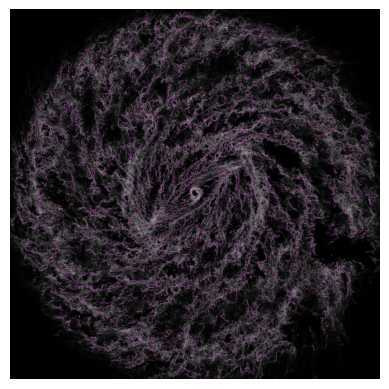

In [73]:
gray_image = image_data

# Check if the image is already in RGB format
if len(gray_image.shape) == 2:  # Grayscale image has only 2 dimensions
    # Convert grayscale image to RGB format
    rgb_image = np.stack([gray_image] * 3, axis=-1)
else:
    rgb_image = gray_image

rgb_image = np.flipud(rgb_image)
# Step 3: Color the coordinates purple
purple = [1, 0, 1]  # RGB for purple
print(rgb_image.shape[0])
print(rgb_image.shape[1])
# Ensure coordinates are within the image bounds
for (y,x) in coordinates:
    if 0 <= x < rgb_image.shape[0] and 0 <= y < rgb_image.shape[1]:
        rgb_image[x, y] = purple

# Step 4: Display the image using Matplotlib
plt.imshow(rgb_image)
plt.axis('off')  # Hide axes
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_45608\3722182361.py:16: RuntimeWarning: overflow encountered in exp
  processed_image = np.where(image > .2, np.exp(image), image)


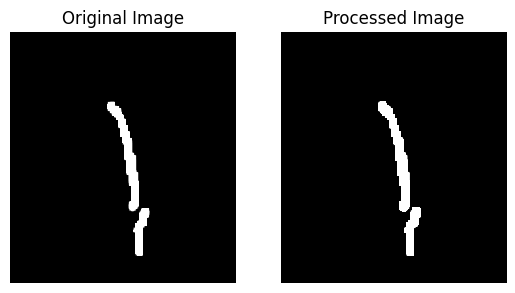

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def process_image(image):
    """
    Process the image by applying an exponential function to pixels greater than 0.2
    and setting pixels less than 0.15 to black (0).

    Parameters:
    - image: 2D numpy array (grayscale image) with values in range [0, 1]

    Returns:
    - Processed image as a 2D numpy array
    """
    # Apply exponential to pixels greater than 0.2
    processed_image = np.where(image > .2, np.exp(image), image)
    
    # Set pixels less than 0.15 to black
    processed_image = np.where(processed_image < .2, 0, processed_image)
    
    return processed_image

# Example usage:
if __name__ == "__main__":
    # Create a sample image (for testing)
    image = image_data

    processed_image = process_image(image)

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Processed Image')
    plt.imshow(processed_image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    plt.show()
    processed_image = processed_image.astype(np.float32)
    fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Thresh.fits',processed_image, overwrite=True)



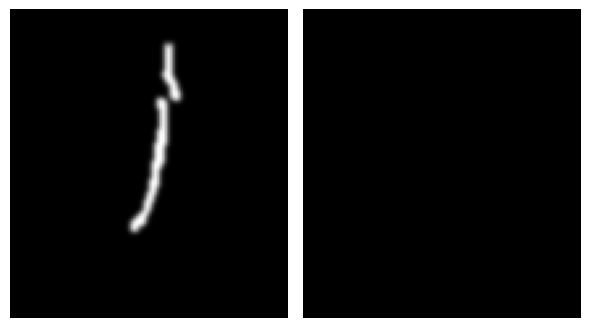

(118, 106)


: 

In [33]:
# importlib.reload(IA)
# importlib.reload(IMF)
# def neighbours(x, y, image):
#     """Return 8-neighbours of image point P1(x,y), in a clockwise order"""
#     img = image
#     x_1, y_1, x1, y1 = x - 1, y - 1, x + 1, y + 1
#     return [img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1], img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1]]

# def getSkeletonIntersection(skeleton):
#     """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton.
    
#     Keyword arguments:
#     skeleton -- the skeletonised image to detect the intersections of
    
#     Returns: 
#     List of 2-tuples (x,y) containing the intersection coordinates
#     """
#     validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
#                          [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
#                          [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
#                          [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
#                          [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
#                          [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
#                          [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
#                          [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
#                          [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
#                          [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
#                          [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
#                          [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
#                          [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
#                          [1,0,1,1,0,1,0,0]]
#     image = skeleton.copy() / 255
#     intersections = []
#     for x in range(1, len(image) - 1):
#         for y in range(1, len(image[x]) - 1):
#             # If we have a white pixel
#             if image[x][y] == 1:
#                 neighbors = neighbours(x, y, image)
#                 if neighbors in validIntersection:
#                     intersections.append((y, x))
    
#     # Filter intersections to make sure we don't count them twice or ones that are very close together
#     filtered_intersections = []
#     for point1 in intersections:
#         add_point = True
#         for point2 in filtered_intersections:
#             if ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2:
#                 add_point = False
#                 break
#         if add_point:
#             filtered_intersections.append(point1)
    
#     return filtered_intersections

# # Apply skeletonization

# # Find the intersections
# intersections = getSkeletonIntersection(np.array(processed_image))

# # Draw intersections on the original image
# #draw_intersections(skeleton_image_path, intersections, output_image_path)

# intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImageNoIntersects.png'

# no_intersects = IA.remove_junctions(intersections, processed_image, intersects_removed, dot_size = 1)

# print(np.shape(no_intersects))

In [5]:
# import numpy as np
# from scipy.ndimage import minimum_filter, maximum_filter

# def local_min_max_normalization(image, window_size):
#     """
#     Perform local min/max normalization on an image using a sliding window.

#     Parameters:
#     - image: 2D numpy array representing the grayscale image to be normalized.
#     - window_size: Size of the sliding window (must be an odd integer).

#     Returns:
#     - normalized_image: 2D numpy array with local min/max normalized values.
#     """
#     # Check that window_size is odd
#     if window_size % 2 == 0:
#         raise ValueError("window_size must be an odd integer.")

#     # Ensure the image is in float format for precision
#     image = image.astype(np.float64)

#     # Compute the local min and max using minimum_filter and maximum_filter
#     local_min = minimum_filter(image, size=window_size, mode='reflect')
#     local_max = maximum_filter(image, size=window_size, mode='reflect')

#     # Perform local min/max normalization
#     # Avoid division by zero by adding a small epsilon to the denominator
#     epsilon = 1e-10
#     normalized_image = (image - local_min) / (local_max - local_min + epsilon)

#     # Clip values to the range [0, 1]
#     normalized_image = np.clip(normalized_image, 0, 1)

#     return normalized_image

# # # Example usage
# # if __name__ == "__main__":
# #     import matplotlib.pyplot as plt

# #     # Create a test image (for demonstration)
# #     test_image = image_data

# #     # Apply local min/max normalization
# #     window_size = 31  # Example window size
# #     normalized_image = local_min_max_normalization(test_image, window_size)

# #     # Display the results
# #     plt.subplot(1, 2, 1)
# #     plt.title('Original Image')
# #     plt.imshow(test_image, cmap='gray')

# #     plt.subplot(1, 2, 2)
# #     plt.title('Normalized Image')
# #     plt.imshow(normalized_image, cmap='gray')

# #     plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_45608\814464048.py:50: RuntimeWarning: divide by zero encountered in divide
  phi = lambda1 / (lambda2 + np.finfo(float).eps)  # Avoid division by zero
C:\Users\HP\AppData\Local\Temp\ipykernel_45608\814464048.py:50: RuntimeWarning: invalid value encountered in divide
  phi = lambda1 / (lambda2 + np.finfo(float).eps)  # Avoid division by zero
C:\Users\HP\AppData\Local\Temp\ipykernel_45608\814464048.py:52: RuntimeWarning: overflow encountered in divide
  sigma_sum = 1 - np.exp(-((lambda1 + lambda2) ** 2) / (2 * beta**2))


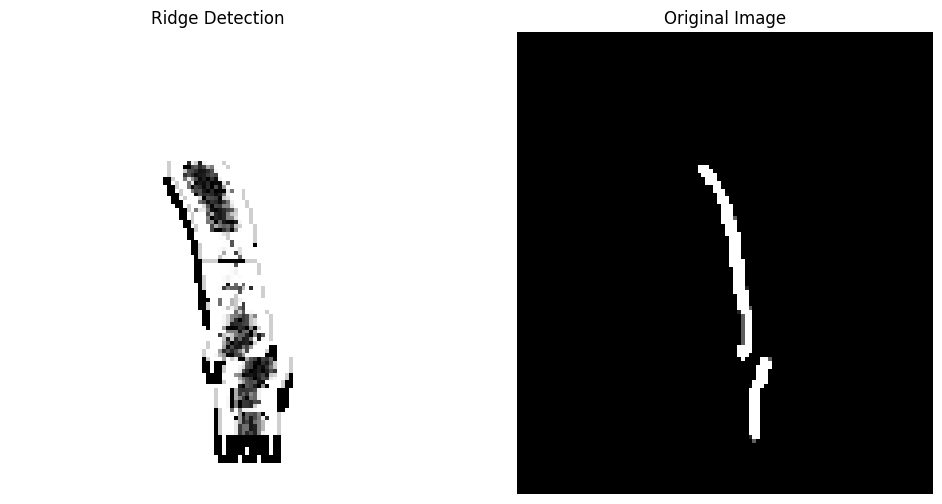

In [6]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import math 
import scipy 
def hessian_matrix(image, sigma):
    """
    Compute the Hessian matrix components.

    Parameters:
    - image: 2D numpy array (grayscale image)
    - sigma: Scale parameter for Gaussian filter

    Returns:
    - Hessian matrix components Ixx, Ixy, Iyy
    """
    Ixx = gaussian_filter(image, sigma=sigma, order=(2, 0))
    Ixy = gaussian_filter(image, sigma=sigma, order=(1, 1))
    Iyy = gaussian_filter(image, sigma=sigma, order=(0, 2))
    return Ixx, Ixy, Iyy

def hessian_eigenvalues(Ixx, Ixy, Iyy):
    """
    Compute the eigenvalues of the Hessian matrix.

    Parameters:
    - Ixx, Ixy, Iyy: Hessian matrix components

    Returns:
    - Eigenvalues lambda1 and lambda2
    """
    trace = Ixx + Iyy
    determinant = Ixx * Iyy - Ixy**2
    discriminant = trace**2 - 4 * determinant
    lambda1 = 0.5 * (trace + np.sqrt(np.maximum(discriminant, 0)))  # Ensure non-negative sqrt
    lambda2 = 0.5 * (trace - np.sqrt(np.maximum(discriminant, 0)))  # Ensure non-negative sqrt
    return lambda1, lambda2

def ridge_filter(lambda1, lambda2, alpha=0.5, beta=0.5):
    """
    Apply a ridge filter to the eigenvalues.

    Parameters:
    - lambda1, lambda2: Eigenvalues of the Hessian matrix
    - alpha, beta: Parameters for ridge filter

    Returns:
    - Ridge response
    """
    # Normalize eigenvalues
    phi = lambda1 / (lambda2 + np.finfo(float).eps)  # Avoid division by zero
    sigma_ratio = 1 - np.exp(-((phi - 1) ** 2) / (2 * alpha**2))
    sigma_sum = 1 - np.exp(-((lambda1 + lambda2) ** 2) / (2 * beta**2))
    response = sigma_ratio * sigma_sum
    return response

def ridge_detection(image, sigma, alpha=0.5, beta=0.5):
    """
    Detect ridges in the image using Hessian matrix and ridge filter.

    Parameters:
    - image: 2D numpy array (grayscale image)
    - sigma: Scale parameter for the Hessian filter
    - alpha, beta: Parameters for ridge filter

    Returns:
    - Ridge response
    """
    if len(image.shape) == 3:
        image = image[:, :, 0]  # Convert to grayscale if necessary
    Ixx, Ixy, Iyy = hessian_matrix(image, sigma)
    lambda1, lambda2 = hessian_eigenvalues(Ixx, Ixy, Iyy)
    response = ridge_filter(lambda1, lambda2, alpha, beta)
    return response


# Example usage
if __name__ == "__main__":
    from skimage import data
    image = image_data
    # local_std = scipy.ndimage.generic_filter(image, np.std, size=5, mode='reflect')

    # # Avoid division by zero by setting small local std deviations to 1
    # local_std[local_std < 1e-8] = 1

    # # Normalize image intensities by the local standard deviation
    # normalized_image = image / local_std

    # print(np.shape(image))
    # img = np.zeros_like((image))
    # print(np.shape(img))
    # Density = []
    # step = 80
    # for x_start in range(0,2000,step):
    #     for y_start in range(0,2000,step):
    #         x_end,y_end = x_start + step, y_start + step
    #         square = image[x_start:x_end, y_start:y_end]
    #         density = np.sum(square)
    #         Density.append(density)
    #         # Parameters
    #         if density !=0: 
    #             sigma = math.log10(density)#33  # Scale parameter for the Hessian filter
    #         else: 
    #             sigma = 3
    #         alpha = .45 # Parameter for ridge filter
    #         beta = .45  # Parameter for ridge filter
    #         threshold = 0.5    # Threshold value for post-processing


    #         # Perform ridge detection
    #         ridge_response = ridge_detection(square, sigma, alpha, beta)
    #         threshold = .2
    #         # Create a mask for pixels where the condition is not met
    #         mask = (ridge_response > 0) & (processed_image[x_start:x_end, y_start:y_end]<= threshold)

    #         # Set those pixels in the summed data to black (0)
    #         ridge_response[mask] = 0
    #         ridge_response[ridge_response < .0003] = 0
    #         ridge_response[ridge_response > .0003] = 255
    #         # img = img.astype(np.float32)
    #         # ridge_response = ridge_response.astype(np.float32)
    #         img[x_start:x_end, y_start:y_end]+=ridge_response    
    #         print(np.min(Density), np.max(Density), np.mean(Density))
    # Display the images
    sigma = 2.7
    alpha = .55
    beta = .55
    ridge_response = ridge_detection(image_data, sigma, alpha, beta)
    # threshold = .1
    # # Create a mask for pixels where the condition is not met
    # mask = (ridge_response > 0) & (image_data<= threshold)

    # # Set those pixels in the summed data to black (0)
    # ridge_response[mask] = 0
    # ridge_response[ridge_response < .00015] = 0
    # ridge_response[ridge_response > .00015] = 255
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(ridge_response, cmap='gray')
    plt.title('Ridge Detection')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image, cmap = 'gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.show()
ridge_response = ridge_response.astype(np.float32)
fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\hessian_result1.fits',ridge_response, overwrite=True)

216


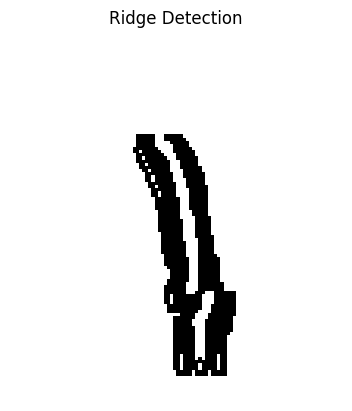

In [7]:
threshold = .2
print(np.max(image_data))
    # # Create a mask for pixels where the condition is not met
mask = (ridge_response > 0) & (image_data<= threshold)

    # # Set those pixels in the summed data to black (0)
ridge_response[mask] = 0
    # ridge_response[ridge_response < .00015] = 0
ridge_response[ridge_response > .00005] = 255
plt.imshow(ridge_response, cmap='gray')
plt.title('Ridge Detection')
plt.axis('off')
plt.show()
fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\hessian_result1.fits',ridge_response, overwrite=True)

In [8]:
# import numpy as np
# import cv2
# from skimage import filters, morphology
# from scipy.ndimage import gaussian_filter
# from scipy.linalg import eigh
# import matplotlib.pyplot as plt

# # Load a sample image
# # For demonstration, we'll use a synthetic image with lines (you can replace this with your image)
# image = img


# # Dilation to smooth filaments
# selem = morphology.disk(3)  # Structuring element
# dilated_image = morphology.dilation(image, selem)

# # Function to compute the structure tensor
# def compute_structure_tensor(image, sigma):
#     # Compute gradients
#     Ix = gaussian_filter(image, sigma, order=[0, 1])
#     Iy = gaussian_filter(image, sigma, order=[1, 0])
    
#     # Compute structure tensor components
#     Ixx = gaussian_filter(Ix * Ix, sigma)
#     Ixy = gaussian_filter(Ix * Iy, sigma)
#     Iyy = gaussian_filter(Iy * Iy, sigma)
    
#     return Ixx, Ixy, Iyy

# # Function to compute orientation-based smoothing
# def orientation_smoothing(Ixx, Ixy, Iyy, sigma):
#     # Compute the eigenvalues and eigenvectors of the structure tensor
#     eigenvalues = np.zeros(Ixx.shape + (2,))
#     eigenvectors = np.zeros(Ixx.shape + (2, 2))
    
#     for i in range(Ixx.shape[0]):
#         for j in range(Ixx.shape[1]):
#             A = np.array([[Ixx[i, j], Ixy[i, j]],
#                           [Ixy[i, j], Iyy[i, j]]])
#             eigvals, eigvecs = eigh(A)
#             eigenvalues[i, j] = eigvals
#             eigenvectors[i, j] = eigvecs
    
#     # Use the orientation (eigenvector) to perform smoothing
#     smoothed_image = np.zeros_like(image)
    
#     for i in range(Ixx.shape[0]):
#         for j in range(Ixx.shape[1]):
#             orientation = eigenvectors[i, j, :, 0]  # Take the first eigenvector
#             # Create a small Gaussian kernel in the direction of the orientation
#             kernel_size = int(2 * sigma + 1)
#             x = np.arange(-kernel_size//2 + 1, kernel_size//2 + 1)
#             y = np.arange(-kernel_size//2 + 1, kernel_size//2 + 1)
#             X, Y = np.meshgrid(x, y)
#             kernel = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
#             kernel = kernel / np.sum(kernel)
            
#             # Apply the kernel in the direction of the orientation
#             for dx in range(-kernel_size//2, kernel_size//2 + 1):
#                 for dy in range(-kernel_size//2, kernel_size//2 + 1):
#                     xi = int(i + dx * orientation[0])
#                     yi = int(j + dy * orientation[1])
#                     if 0 <= xi < Ixx.shape[0] and 0 <= yi < Ixx.shape[1]:
#                         smoothed_image[i, j] += image[xi, yi] * kernel[dx + kernel_size//2, dy + kernel_size//2]
    
#     return smoothed_image

# # Compute structure tensor
# sigma = 3.0  # Standard deviation for Gaussian smoothing
# Ixx, Ixy, Iyy = compute_structure_tensor(image, sigma)

# # Compute orientation-based smoothing
# smoothed_image = orientation_smoothing(Ixx, Ixy, Iyy, sigma)

# # Create a figure to display the results
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# # Original Image
# ax[0].imshow(image, cmap='gray')
# ax[0].set_title('Original Image')
# ax[0].axis('off')

# # Dilated Image
# ax[1].imshow(dilated_image, cmap='gray')
# ax[1].set_title('Dilated Image')
# ax[1].axis('off')

# # Orientation-based Smoothed Image
# ax[2].imshow(smoothed_image, cmap='gray')
# ax[2].set_title('Orientation-based Smoothed Image')
# ax[2].axis('off')

# plt.show()

# fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\hessian_result1.fits',dilated_image, overwrite=True)
# fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\hessian_result2.fits',smoothed_image, overwrite=True)




In [9]:
# import numpy as np
# import matplotlib.pyplot as plt

# def update_center_pixel(image, kernel_size, total_white_required):
#     """
#     Update the center pixel of the image to white if the conditions are met:
#     1. There are white pixels on at least two sides of the kernel.
#     2. The total number of white pixels in the kernel meets or exceeds the required number.

#     Parameters:
#     - image: 2D numpy array (grayscale image)
#     - kernel_size: Size of the square kernel (e.g., 3 for a 3x3 kernel)
#     - total_white_required: Total number of white pixels required to fill in the center

#     Returns:
#     - Updated image with center pixels set to white based on the conditions
#     """
#     # Create a padded image to handle edges
#     pad_size = kernel_size // 2
#     padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
#     updated_image = np.copy(image)
    
#     # Slide the kernel over the image
#     for i in range(pad_size, padded_image.shape[0] - pad_size):
#         for j in range(pad_size, padded_image.shape[1] - pad_size):
#             # Extract the kernel
#             kernel = padded_image[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
#             center_pixel = kernel[kernel_size // 2, kernel_size // 2]
            
#             # Count white pixels in the kernel
#             white_pixels = np.sum(kernel == 1)
            
#             # Check white pixels on at least two sides
#             top = np.any(kernel[0, 1:-1] == 1)
#             bottom = np.any(kernel[-1, 1:-1] == 1)
#             left = np.any(kernel[1:-1, 0] == 1)
#             right = np.any(kernel[1:-1, -1] == 1)
            
#             sides_with_white = sum([top, bottom, left, right])
            
#             # Update the center pixel if conditions are met
#             if center_pixel == 0 and sides_with_white >= 2 and white_pixels >= total_white_required:
#                 updated_image[i - pad_size, j - pad_size] = 1  # Set the center pixel to white
    
#     return updated_image

# # Example usage:
# if __name__ == "__main__":
#     # Create a sample image (for testing)
#     image = img

#     kernel_size = 11  # Use a 3x3 kernel
#     total_white_required = 21  # Total number of white pixels required to fill in the center

#     updated_image = update_center_pixel(image, kernel_size, total_white_required)

#     plt.subplot(1, 2, 1)
#     plt.title('Original Image')
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.title('Updated Image')
#     plt.imshow(updated_image, cmap='gray')
#     plt.axis('off')

#     plt.show()
# fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\hessian_result1.fits',updated_image, overwrite=True)


In [10]:
# fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\hessian_result1.fits',updated_image, overwrite=True)


In [11]:
# threshold_value = 0.5  # Define the threshold value
# binary_image = (updated_image > threshold_value).astype(np.uint8)
# skeleton_image = skeletonize(binary_image).astype(np.float32)
# fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\hessian_result2.fits',skeleton_image, overwrite=True)


In [12]:
# importlib.reload(IA)
# importlib.reload(IMF)
# def neighbours(x, y, image):
#     """Return 8-neighbours of image point P1(x,y), in a clockwise order"""
#     img = image
#     x_1, y_1, x1, y1 = x - 1, y - 1, x + 1, y + 1
#     return [img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1], img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1]]

# def getSkeletonIntersection(skeleton):
#     """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton.
    
#     Keyword arguments:
#     skeleton -- the skeletonised image to detect the intersections of
    
#     Returns: 
#     List of 2-tuples (x,y) containing the intersection coordinates
#     """
#     validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
#                          [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
#                          [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
#                          [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
#                          [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
#                          [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
#                          [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
#                          [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
#                          [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
#                          [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
#                          [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
#                          [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
#                          [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
#                          [1,0,1,1,0,1,0,0]]
#     image = skeleton.copy() / 255
#     intersections = []
#     for x in range(1, len(image) - 1):
#         for y in range(1, len(image[x]) - 1):
#             # If we have a white pixel
#             if image[x][y] == 1:
#                 neighbors = neighbours(x, y, image)
#                 if neighbors in validIntersection:
#                     intersections.append((y, x))
    
#     # Filter intersections to make sure we don't count them twice or ones that are very close together
#     filtered_intersections = []
#     for point1 in intersections:
#         add_point = True
#         for point2 in filtered_intersections:
#             if ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2:
#                 add_point = False
#                 break
#         if add_point:
#             filtered_intersections.append(point1)
    
#     return filtered_intersections

# # Apply skeletonization

# # Find the intersections
# intersections = getSkeletonIntersection(np.array(255*skeleton_image))

# # Draw intersections on the original image
# #draw_intersections(skeleton_image_path, intersections, output_image_path)

# intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImageNoIntersects.png'

# no_intersects = IA.remove_junctions(intersections, skeleton_image, intersects_removed, dot_size = 2)

# print(np.shape(no_intersects))

In [13]:
importlib.reload(IA)
    # Clip values to range [0, 255]
    
    # Convert to 8-bit grayscale image
img = ridge_response
img = img.astype(np.uint8)
labels, stats, num_labels = IA.identify_connected_components(np.array(img))

C:\Users\HP\AppData\Local\Temp\ipykernel_45608\1758564911.py:6: RuntimeWarning: invalid value encountered in cast
  img = img.astype(np.uint8)


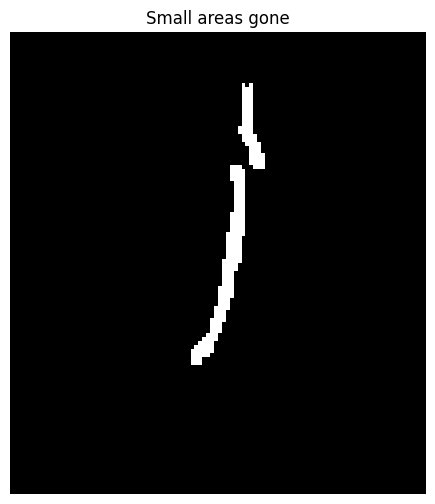

In [14]:
importlib.reload(IA)
small_areas = IA.sort_label_id(num_labels, stats, 20)
labels, stats, num_labels = IA.identify_connected_components(np.array(img))
for label_id in small_areas:
    # Extract the bounding box coordinates
    left = stats[label_id, cv2.CC_STAT_LEFT]
    top = stats[label_id, cv2.CC_STAT_TOP]
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]
    for x in range(width):
        for y in range(height):
            img[top:top+height, left:left+width] = 0


# Set the desired figure size (width, height) in inches
fig_size = (6, 6)  # Adjust this to your desired size

# Create a figure with the specified size
plt.figure(figsize=fig_size)

# Display the thresholded image (optional)
plt.imshow(np.flipud(img), cmap='gray')
plt.axis('off')  # Turn off axes
plt.title('Small areas gone')
plt.show()


cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SmallFilamentsGone.png', img)

# Save as FITS
skel_image_file_fits = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SPRSkel1.fits'   
hdu = fits.PrimaryHDU(img)
hdul = fits.HDUList([hdu])
hdul.writeto(skel_image_file_fits, overwrite=True)

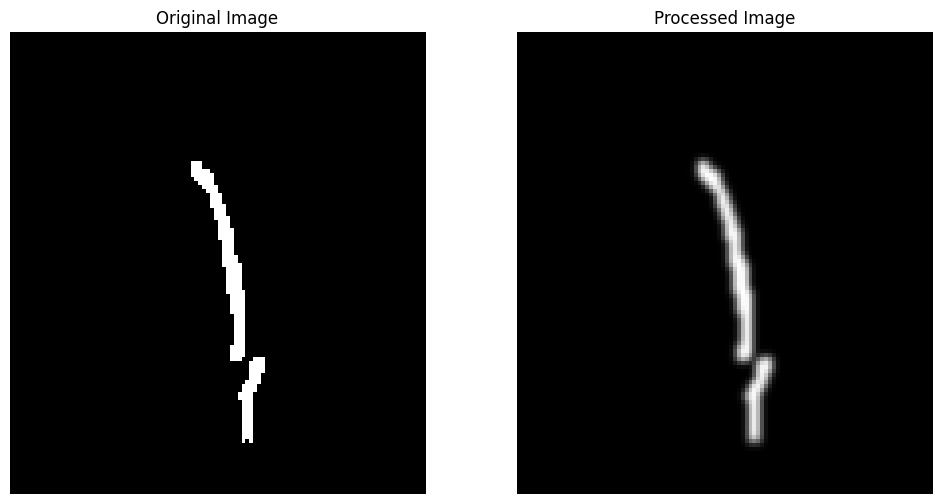

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def infill_small_black_pixels(image, inpaint_radius=3, max_region_size=10, smooth_radius=1):
    """
    Infill small black pixels in an image and smooth the result.
    
    Parameters:
    - image: 2D numpy array (grayscale image, 8-bit)
    - inpaint_radius: Radius for the inpainting algorithm
    - max_region_size: Maximum size of regions to be inpainted (in pixels)
    - smooth_radius: Radius for Gaussian smoothing
    
    Returns:
    - processed_image: Image with small black pixels filled and smoothed
    """
    # Ensure the image is in grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Convert image to 8-bit format if not already
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(image)
    
    # Create a mask for black pixels
    black_mask = (image == 0).astype(np.uint8)
    
    # Find all connected components (regions of black pixels)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(black_mask, connectivity=8)
    
    # Create a mask for small regions only
    small_region_mask = np.zeros_like(black_mask, dtype=np.uint8)
    
    for i in range(1, num_labels):  # Skip label 0 (background)
        x, y, w, h, area = stats[i]
        if area < max_region_size:
            small_region_mask[labels == i] = 255
    
    # Inpaint small regions by applying inpainting
    inpainted_image = cv2.inpaint(image, small_region_mask, inpaint_radius, cv2.INPAINT_TELEA)
    
    # Apply Gaussian smoothing
    smoothed_image = cv2.GaussianBlur(inpainted_image, (0, 0), smooth_radius)
    
    return smoothed_image

# Example usage
if __name__ == "__main__":
    # Load example image
    image = img
    
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    # Infill small black pixels
    processed_image = infill_small_black_pixels(image, inpaint_radius=3, max_region_size=35, smooth_radius=1)
    
    # Display the original and processed images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image, cmap='gray')
    plt.title('Processed Image')
    plt.axis('off')

    plt.show()
    fits.writeto(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Thresh1.fits',processed_image, overwrite=True)

image = processed_image
    # image_data = processed_image


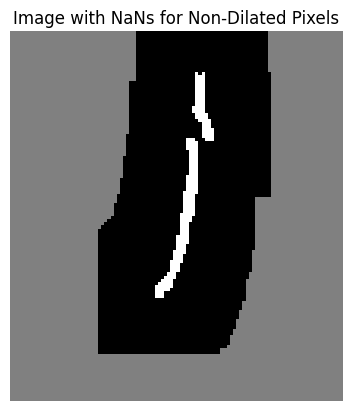

In [23]:
import copy
image = img
min_val = np.min(image)
max_val = np.max(image)

# Apply min-max normalization
normalized_image = (image - min_val) / (max_val - min_val + np.finfo(float).eps)  # Adding epsilon to avoid division by zero

image_data = 255*normalized_image
mask_copy = copy.deepcopy(image_data)
mask_copy[mask_copy != 0] = 255
mask_copy = mask_copy.astype(np.uint8)

# Define the kernel size for dilation
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Perform dilation
dilated_image = cv2.dilate(mask_copy, kernel, iterations=30)

# Convert dilated_image to float32 to handle NaN values
image_data = image_data.astype(np.float32)

# Set non-dilated pixels to NaN
image_data[dilated_image == 0] = np.nan

# Create a colormap with NaNs as a specific color
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('nan_color', [(0, 0, 0), (1, 1, 1)], N=256)
cmap.set_bad('gray')  # Set NaNs to a color (e.g., gray)

# Step 1: Create a mask for NaN values
mask = np.isnan(image_data)

# Create a binary mask where NaNs are 0 and non-NaNs are 255
binary_mask = np.zeros_like(image_data, dtype=np.uint8)
binary_mask[mask] = 255
binary_mask[~mask] = 0

# Step 2: Define the kernel size for dilation
kernel_size = 9
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Perform dilation on the binary mask
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=3)

# Step 3: Create a copy of the original image
dilated_image = copy.deepcopy(image_data)

# Replace the original NaN areas with the dilated mask
# Here, 0s in the dilated mask correspond to NaNs in the original image
dilated_image[dilated_mask==255] = np.nan
dilated_image[dilated_image > 10] = 255
# Create a colormap with NaNs as a specific color
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('nan_color', [(0, 0, 0), (1, 1, 1)], N=256)
cmap.set_bad('gray')  # Set NaNs to a color (e.g., gray)

# Display the modified image_data with NaNs
plt.imshow(np.flipud(dilated_image), cmap=cmap)
plt.axis('off')  # Hide axis
plt.title('Image with NaNs for Non-Dilated Pixels')
plt.show()


255.0 0.0
DETECTING
deblending


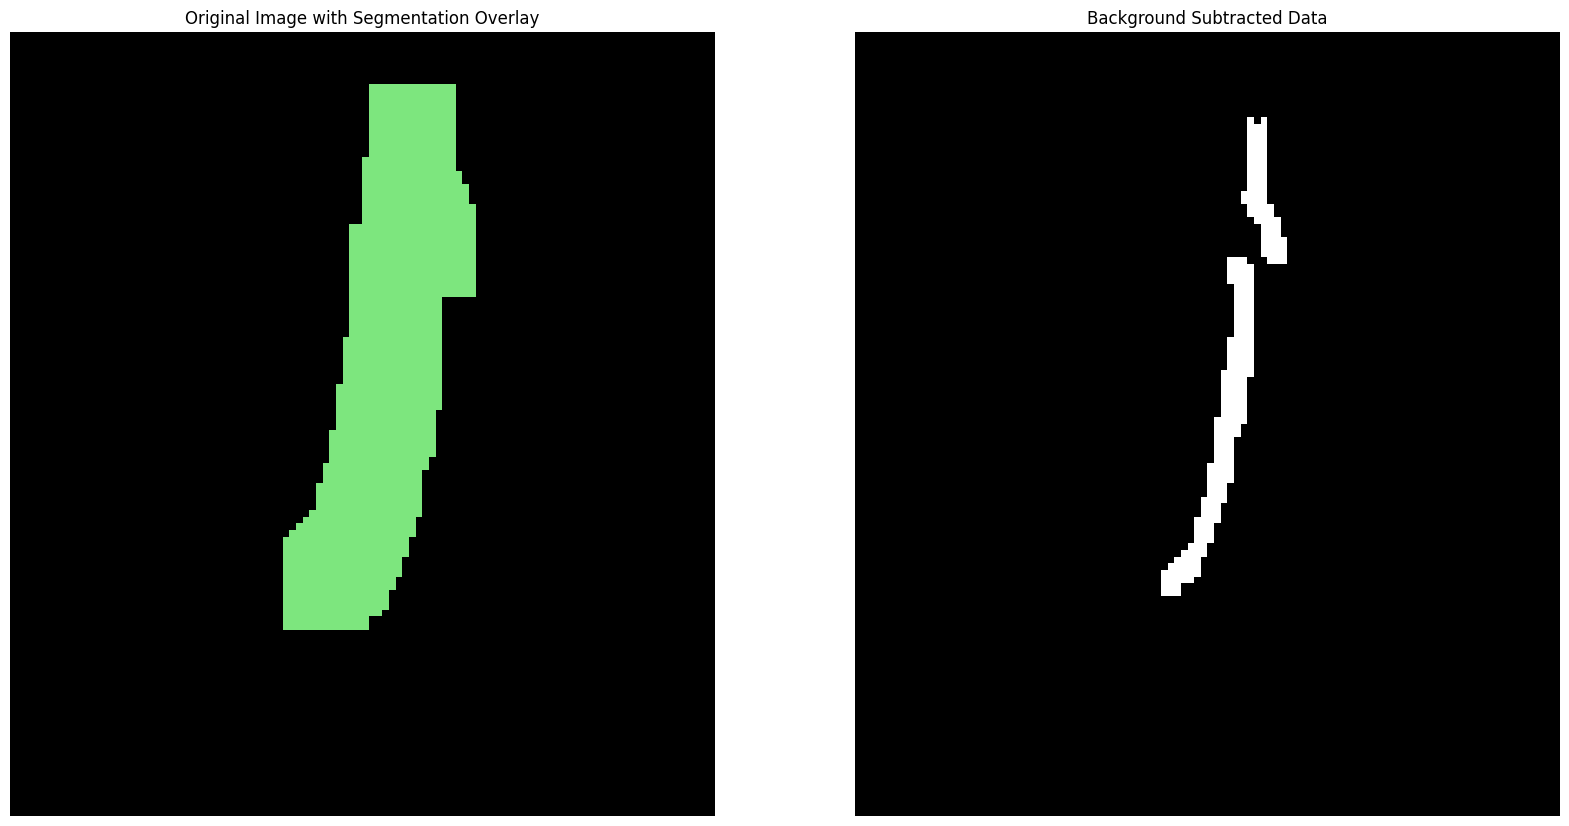

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from matplotlib.colors import ListedColormap

source_pixel_min = 200
deblend_pixel_min = 100
threshold_factor = .7

path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SmallFilamentsGone.png'
# data = dilated_image
data = img
data = data.astype(np.float64)
print(np.max(data), np.min(data))
# Background subtraction
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Thresholding and convolution
threshold = threshold_factor*bkg.background_rms
kernel = make_2dgaussian_kernel(3.0, size=11)
convolved_data = convolve(data, kernel)

# Source detection and deblending
print('DETECTING')
segment_map = detect_sources(convolved_data, threshold, npixels=int(source_pixel_min))
print("deblending")
segment_map = deblend_sources(convolved_data, segment_map, npixels=int(deblend_pixel_min), nlevels=100, contrast=0.001, progress_bar=False)

# Colormap and normalization
num_segments = segment_map.data.max()
colors = np.random.rand(num_segments + 1, 3)
colors[0] = [0, 0, 0]  # Background as black
cmap = ListedColormap(colors)

norm = ImageNormalize(stretch=SqrtStretch())
segmentation_image_normalized = norm(segment_map.data)

#segmentation_image_flipped = np.flipud(segmentation_image_normalized)
#data_flipped = np.flipud(data)

# Plot and save
fig, axes = plt.subplots(1, 2, figsize=(20, 12.5))

axes[0].imshow(segmentation_image_normalized, origin='lower', cmap=cmap, alpha=1, interpolation='nearest')
axes[0].set_title('Original Image with Segmentation Overlay')
axes[0].axis('off')

axes[1].imshow(data, cmap='gray', origin='lower')
axes[1].set_title('Background Subtracted Data')
axes[1].axis('off')

# Save the subplot image
subplot_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\overlaid_subplot_image.png'
plt.imsave(subplot_image_path, np.flipud(segmentation_image_normalized), cmap=cmap)

# Save the binary segmented image
binary_segment_image = (segment_map.data > 0).astype(np.uint8) * 255
image_path_segments = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\segments.png'
plt.imsave(image_path_segments, np.flipud(binary_segment_image), cmap='gray')

# Normalize and save the zoomed image
#data_flipped = data_flipped.astype(np.uint8) * 255
data= np.nan_to_num(data, nan=0)
image_path_zoomed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\zoomed_image.png'
plt.imsave(image_path_zoomed, np.flipud(data), cmap='gray')

# Show the plot
plt.show()


In [331]:
# Save as FITS
skel_image_file_fits = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skimageHess.fits'
img = skeletonize(binary_segment_image)
threshold = 0
# Create a mask for pixels where the condition is not met
mask = (img > 0) & (image_data<= threshold)

# Set those pixels in the summed data to black (0)
img[mask] = 0
img = img.astype(np.float32)  
hdu = fits.PrimaryHDU(img)
hdul = fits.HDUList([hdu])
hdul.writeto(skel_image_file_fits, overwrite=True)

on filament 1 out of 131
on filament 2 out of 131
on filament 3 out of 131
on filament 4 out of 131
on filament 5 out of 131
on filament 6 out of 131
on filament 7 out of 131
on filament 8 out of 131
on filament 9 out of 131
on filament 10 out of 131
on filament 11 out of 131
on filament 12 out of 131
on filament 13 out of 131
on filament 14 out of 131
on filament 15 out of 131
on filament 16 out of 131
on filament 17 out of 131
on filament 18 out of 131
on filament 19 out of 131
on filament 20 out of 131
on filament 21 out of 131
on filament 22 out of 131
on filament 23 out of 131
on filament 24 out of 131
on filament 25 out of 131
on filament 26 out of 131
on filament 27 out of 131
on filament 28 out of 131
on filament 29 out of 131
on filament 30 out of 131
on filament 31 out of 131
on filament 32 out of 131
on filament 33 out of 131
on filament 34 out of 131
on filament 35 out of 131
on filament 36 out of 131
on filament 37 out of 131
on filament 38 out of 131
on filament 39 out of

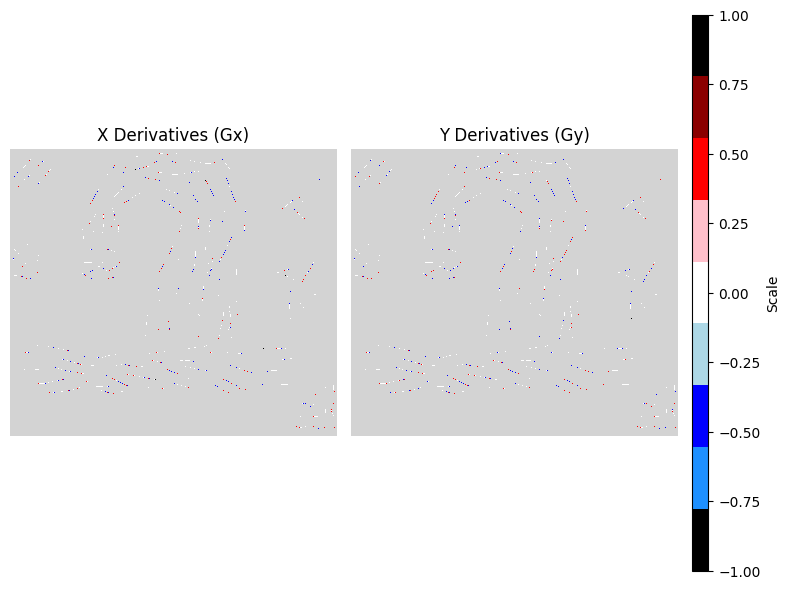

In [332]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import importlib

# Assuming segment_map is already defined from previous segmentation process


original_image = processed_image
# Read the binary segmented image

img = binary_segment_image

# Number of segments
num_segments = segment_map.data.max()

# Initialize Gx and Gy matrices to store results for the entire image
Gx_total = np.zeros_like(img, dtype=np.float64)
Gy_total = np.zeros_like(img, dtype=np.float64)
skel = np.zeros_like(img, dtype=np.float64)

# Loop through each segment to create and display individual masks
for i in range(1, num_segments + 1):
    print(f"on filament {i} out of {num_segments}")
    # Create a mask where only the current segment is white
    mask = np.zeros_like(segment_map.data, dtype=np.uint8)
    mask[segment_map.data == i] = 255
    img[(mask == 255)] = 255  # Keep white where mask and processed_img are both white
    img[(mask != 255)] = 0    # Set all other pixels to black

    img = skeletonize(img)    
    longest_path = IMF.skeleton_analysis(img, original_image, prune=False, prune_criteria='length', relintens_thresh=0.5,
                      branch_thresh=None, verbose=False, save_png=False, save_name=None)
    
    # plt.imshow(img, cmap = "gray")
    # plt.show()

    # Convert skeleton to 8-bit format
    longest_path = (longest_path * 255).astype(np.uint8)

    # Apply Sobel filter to the masked component
    sobelx = cv2.Sobel(longest_path, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(longest_path, cv2.CV_64F, 0, 1, ksize=3)
    
    skel+=longest_path
    Gx_total += sobelx
    Gy_total += sobely

PF.plot_sobel_derivatives(skel, Gx_total, Gy_total)


In [333]:
# Save as FITS
skel_image_file_fits = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\longestPath2.fits'
hdu = fits.PrimaryHDU(skel)
hdul = fits.HDUList([hdu])
hdul.writeto(skel_image_file_fits, overwrite=True)

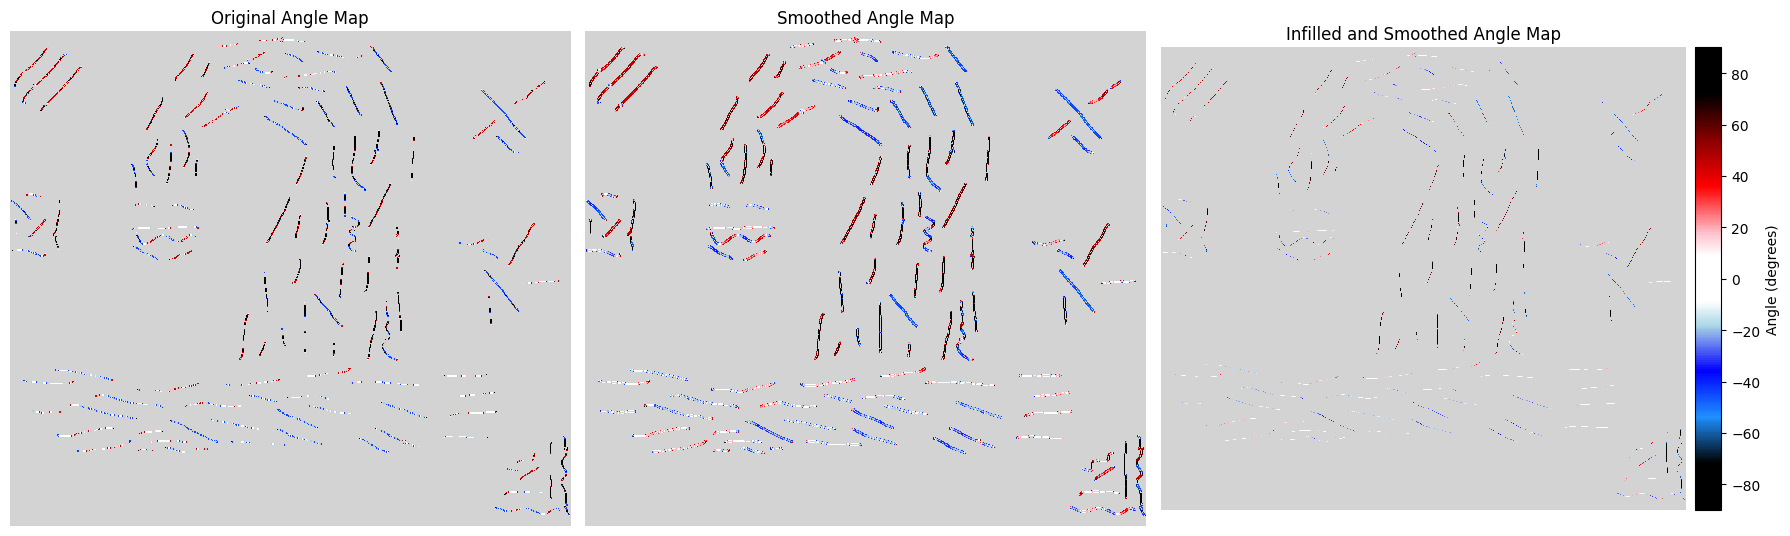

Smoothed angle map saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png


In [338]:
importlib.reload(PF)
smoothed_angles = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'

smoother_angle_map, smoothed_angled_map = PF.plot_arctan_with_smoothing(Gy_total, Gx_total, skel, 3, smoothed_angles)

nan
nan
Number of hexagons: 196
64.90448050842515 7.57400871937088


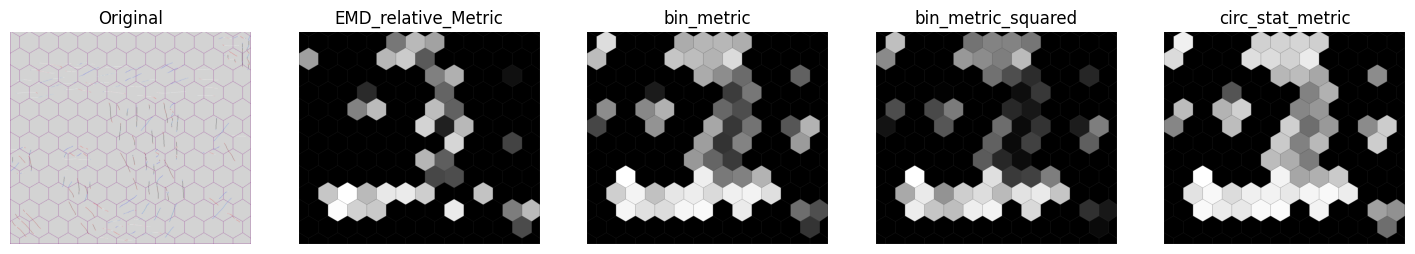

In [339]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import csv
import importlib

# Reload your GUI module if necessary
importlib.reload(myGUI)
importlib.reload(Metric)
import pandas as pd 
import RHT 
import math 
import CircularEMDTest as CT
importlib.reload(CT)
importlib.reload(IA)
importlib.reload(CT)
importlib.reload(RHT)
# Paths and image loading
angle_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
angle_img = cv2.imread(angle_image_path, cv2.COLOR_BGR2RGB)

hex_sizes = [60]

for hexagon_size in hex_sizes: 
    # Hexagon settings
    hexagons, hexagon_image_og = myGUI.display_image_with_hexagons(angle_image_path, hexagon_size)
    hexagon_centers = [x[0] for x in hexagons]
    hexagon_corners = [x[1] for x in hexagons]
    hex_dict = {}

    # Path to the original image
    # Load the original image in grayscale mode
    original_img = data


    for i in range(len(hexagon_corners)):
        
        EMD_sum = 0
        alignment_sum = 0
        hist_metric_sum = 0
        RHT_sum = 0
        for j in range(3):
            if j == 0:
                shift_x = 0
                shift_y = 0
            elif j ==1: 
                shift_x = -(hexagon_corners[i][5][0] - hexagon_centers[i][0])
                shift_y = -(hexagon_corners[i][5][1] - hexagon_centers[i][1])
            elif j == 2:
                shift_x = -(hexagon_corners[i][2][0] - hexagon_centers[i][0])
                shift_y = -(hexagon_corners[i][2][1] - hexagon_centers[i][1])
            # Apply shift to all corners for the current `j`
            shifted_corners = [(x + shift_x, y + shift_y) for (x, y) in hexagon_corners[i]]

            mask = myGUI.get_hexagon_mask(image_data.shape, shifted_corners)

            data_in_hexagon = smoother_angle_map[mask == 255]
            data_in_hexagon = [x for x in data_in_hexagon if not np.isnan(x)]
            # Assuming skel, mask, smoother_angle_map, image_data, and IA.identify_connected_components are defined

            # Convert skel to uint8 for compatibility with cv2 functions
            skel = skel.astype(np.uint8)

            # Apply the binary mask to skel. Where mask == 255, skel values are preserved; otherwise, set to 0.
            masked_skel = np.where(mask == 255, skel, 0).astype(np.uint8)
            # Create a figure and two subplots (side by side)

            labels, stats, num_labels = IA.identify_connected_components(masked_skel.astype(np.uint8))
            if (num_labels-1) != 0 and len(data_in_hexagon) > 30:
                # fig, ax = plt.subplots(1, 3, figsize=(12, 6))  # Adjust figsize as needed

                # # Display masked_skel in the first subplot
                # ax[0].imshow(masked_skel, cmap='gray')
                # ax[0].set_title('Masked Skeleton')
                # ax[0].axis('off')  # Hide the axis
                # # Display mask in the second subplot
                # ax[2].imshow(mask, cmap='gray')
                # ax[2].set_title('Mask')
                # ax[2].axis('off')  # Hide the axis
                # # Display mask in the second subplot
                # ax[1].imshow(skel, cmap='gray')
                # ax[1].set_title('Mask')
                # ax[1].axis('off')  # Hide the axis

                # # Show the plot
                # plt.tight_layout()  # Adjust layout to prevent overlap
                # plt.show()
                # # Identify connected components in the masked skeleton image
                # print(num_labels-1)
            # Dictionary to hold segment data
                segment_dict = {}
                RHT_dict = {}
                for segment in range(1, num_labels):
                    # Extract the bounding box coordinates for the segment
                    x, y, w, h, _ = stats[segment]

                    # Create a mask for the segment
                    seg_mask = np.zeros_like(skel, dtype=np.uint8)
                    seg_mask[y:y+h, x:x+w] = 255

                    # Apply the segment mask to the skeleton image
                    # Ensure both masks are of type uint8
                    segment_mask = cv2.bitwise_and(skel, seg_mask)
                    theta, R, quantiles = RHT.rht(255*segment_mask, radius=10, ntheta=180, background_percentile=25, verbose=False)
                    orientation = quantiles[1]*-180/math.pi
                    # Collect pixel values for the segment
                    # Ensure segment_mask is boolean for indexing
                    segment_mask_bool = segment_mask > 0
                    segment_data = smoother_angle_map[segment_mask_bool]
                    segment_data = [x for x in segment_data if not np.isnan(x)]

                    # Skip the segment if segment_data is empty
                    if len(segment_data) < 10:
                        continue
                    # plt.imshow(segment_mask, cmap = 'gray')
                    # plt.show()
                    # print(f'Orientation: {orientation}')
                    # Ensure segment_mask is used properly for indexing
                    intensity = np.sum(segment_mask_bool)

                    # Store segment data in the dictionary
                    segment_dict[segment] = (segment_data, intensity)
                    pixels = smoother_angle_map[segment_mask_bool]
                    RHT_dict[segment] = (orientation, intensity, pixels)
                if len(segment_dict.keys()) >= 2:
                    EMD_sum += CT.compute_my_metric(segment_dict)
                    RHT_sum +=RHT.RHTMetric(RHT_dict)
                    # print(RHT_sum)
                    # print(RHT_dict)
                else:
                    EMD_sum += np.nan
                    RHT_sum += np.nan
                alignment_sum  += Metric.alignment_metric(data_in_hexagon)
                hist_metric_sum += Metric.compute_my_metric(data_in_hexagon)

            else:

                EMD_sum += np.nan
                alignment_sum   += np.nan
                hist_metric_sum  += np.nan
                RHT_sum += np.nan

        hex_dict[hexagon_centers[i]] = (EMD_sum/3, len(data_in_hexagon), num_labels-1, alignment_sum/3,hist_metric_sum/3, shifted_corners, RHT_sum/3)

    print(f'Number of hexagons: {len(hexagon_centers)}')

    # Create a new image to draw the hexagons filled with the alignment metric colors
    hexagon_image1 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image2 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image3 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image4 = Image.new("RGB", (img.shape[1], img.shape[0]))

    draw1 = ImageDraw.Draw(hexagon_image1)
    draw2 = ImageDraw.Draw(hexagon_image2)
    draw3 = ImageDraw.Draw(hexagon_image3)
    draw4 = ImageDraw.Draw(hexagon_image4)

    count = 0

    # Save hex_dict to CSV
    csv_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thresholded_image.csv'
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Hexagon Center', 'Number of Pixels', 'num_segments','EMD relative Metric', 'my hist metric', 'my hist metric sq', 'circ stat metric'])

        # Extract the first elements from each tuple
        EMD_metrics = [info[0] for info in hex_dict.values() if not np.isnan(info[0])]
        hist_metrics = [info[4] for info in hex_dict.values() if not np.isnan(info[4])]

        # Calculate the max and min values of the first elements
        EMD_max_metric = max(EMD_metrics)
        EMD_min_metric = min(EMD_metrics)
        hist_max_metric = max(hist_metrics)
        hist_min_metric = min(hist_metrics)
        print(EMD_max_metric, EMD_min_metric)
        for center, info in hex_dict.items():
            EMD_metric = info[0]
            circ_stat_metric = info[3]
            hist_metric = info[4]
            number_of_pixels = info[1]
            segments = info[2]

            EMD_relative_metric = (EMD_metric - EMD_min_metric) / (EMD_max_metric - EMD_min_metric)
            hist_relative_metric = (hist_metric - hist_min_metric) / (hist_max_metric - hist_min_metric)

            # Check if segments is an empty list or contains NaN
            if not segments or isinstance(segments, float) and np.isnan(segments):
                num_seg = 0
            else:
                num_seg = segments

            writer.writerow([center, number_of_pixels, 1 - EMD_relative_metric, hist_metric, hist_metric**2, circ_stat_metric, num_seg])
            if not np.isnan(hist_metric):
                grayscale_value2 = int(255*hist_metric)
                grayscale_value3 = int(255*(hist_metric**2))  # Map to grayscale (0 to 255)
                grayscale_value4 = int(255*circ_stat_metric)
                corners = hexagon_corners[count]
                draw2.polygon(corners, fill=(grayscale_value2, grayscale_value2, grayscale_value2), outline="purple")
                draw3.polygon(corners, fill=(grayscale_value3, grayscale_value3, grayscale_value3), outline="purple")
                draw4.polygon(corners, fill=(grayscale_value4, grayscale_value4, grayscale_value4), outline="purple")
            else:
                corners = hexagon_corners[count]
                draw2.polygon(corners, fill=(0, 0, 0), outline="purple")
                draw3.polygon(corners, fill=(0, 0, 0), outline="purple")
                draw4.polygon(corners, fill=(0, 0, 0), outline="purple")
            if not np.isnan(EMD_relative_metric):
                grayscale_value1 = int(255 - EMD_relative_metric * 255)  # Map to grayscale (0 to 255)
                draw1.polygon(corners, fill=(grayscale_value1, grayscale_value1, grayscale_value1), outline="purple")
            else:
                corners = hexagon_corners[count]
                draw1.polygon(corners, fill=(0, 0, 0), outline="purple")
            count += 1

    # Convert PIL images to numpy arrays
    hexagon_image1_array = np.array(hexagon_image1.convert('L'))
    hexagon_image2_array = np.array(hexagon_image2.convert('L'))
    hexagon_image3_array = np.array(hexagon_image3.convert('L'))
    hexagon_image4_array = np.array(hexagon_image4.convert('L'))

    # Display the original and processed images with grayscale colormap
    fig, ax = plt.subplots(1, 5, figsize=(18, 18))  # Adjust the figsize as needed

    ax[0].imshow(np.flipud(hexagon_image_og))
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(np.flipud(hexagon_image1_array), cmap='gray')
    ax[1].set_title('EMD_relative_Metric')
    ax[1].axis('off')

    ax[2].imshow(np.flipud(hexagon_image2_array), cmap='gray')
    ax[2].set_title('bin_metric')
    ax[2].axis('off')

    ax[3].imshow(np.flipud(hexagon_image3_array), cmap='gray')
    ax[3].set_title('bin_metric_squared')
    ax[3].axis('off')

    ax[4].imshow(np.flipud(hexagon_image4_array), cmap='gray')
    ax[4].set_title('circ_stat_metric')
    ax[4].axis('off')

    # Define your hexagon images as numpy arrays
    hexagon_images = {
        'EMD_relative_Metric': hexagon_image1_array,
        'bin_metric': hexagon_image2_array,
        'bin_metric_squared': hexagon_image3_array,
        'circ_stat_metric': hexagon_image4_array
    }

    plt.show()


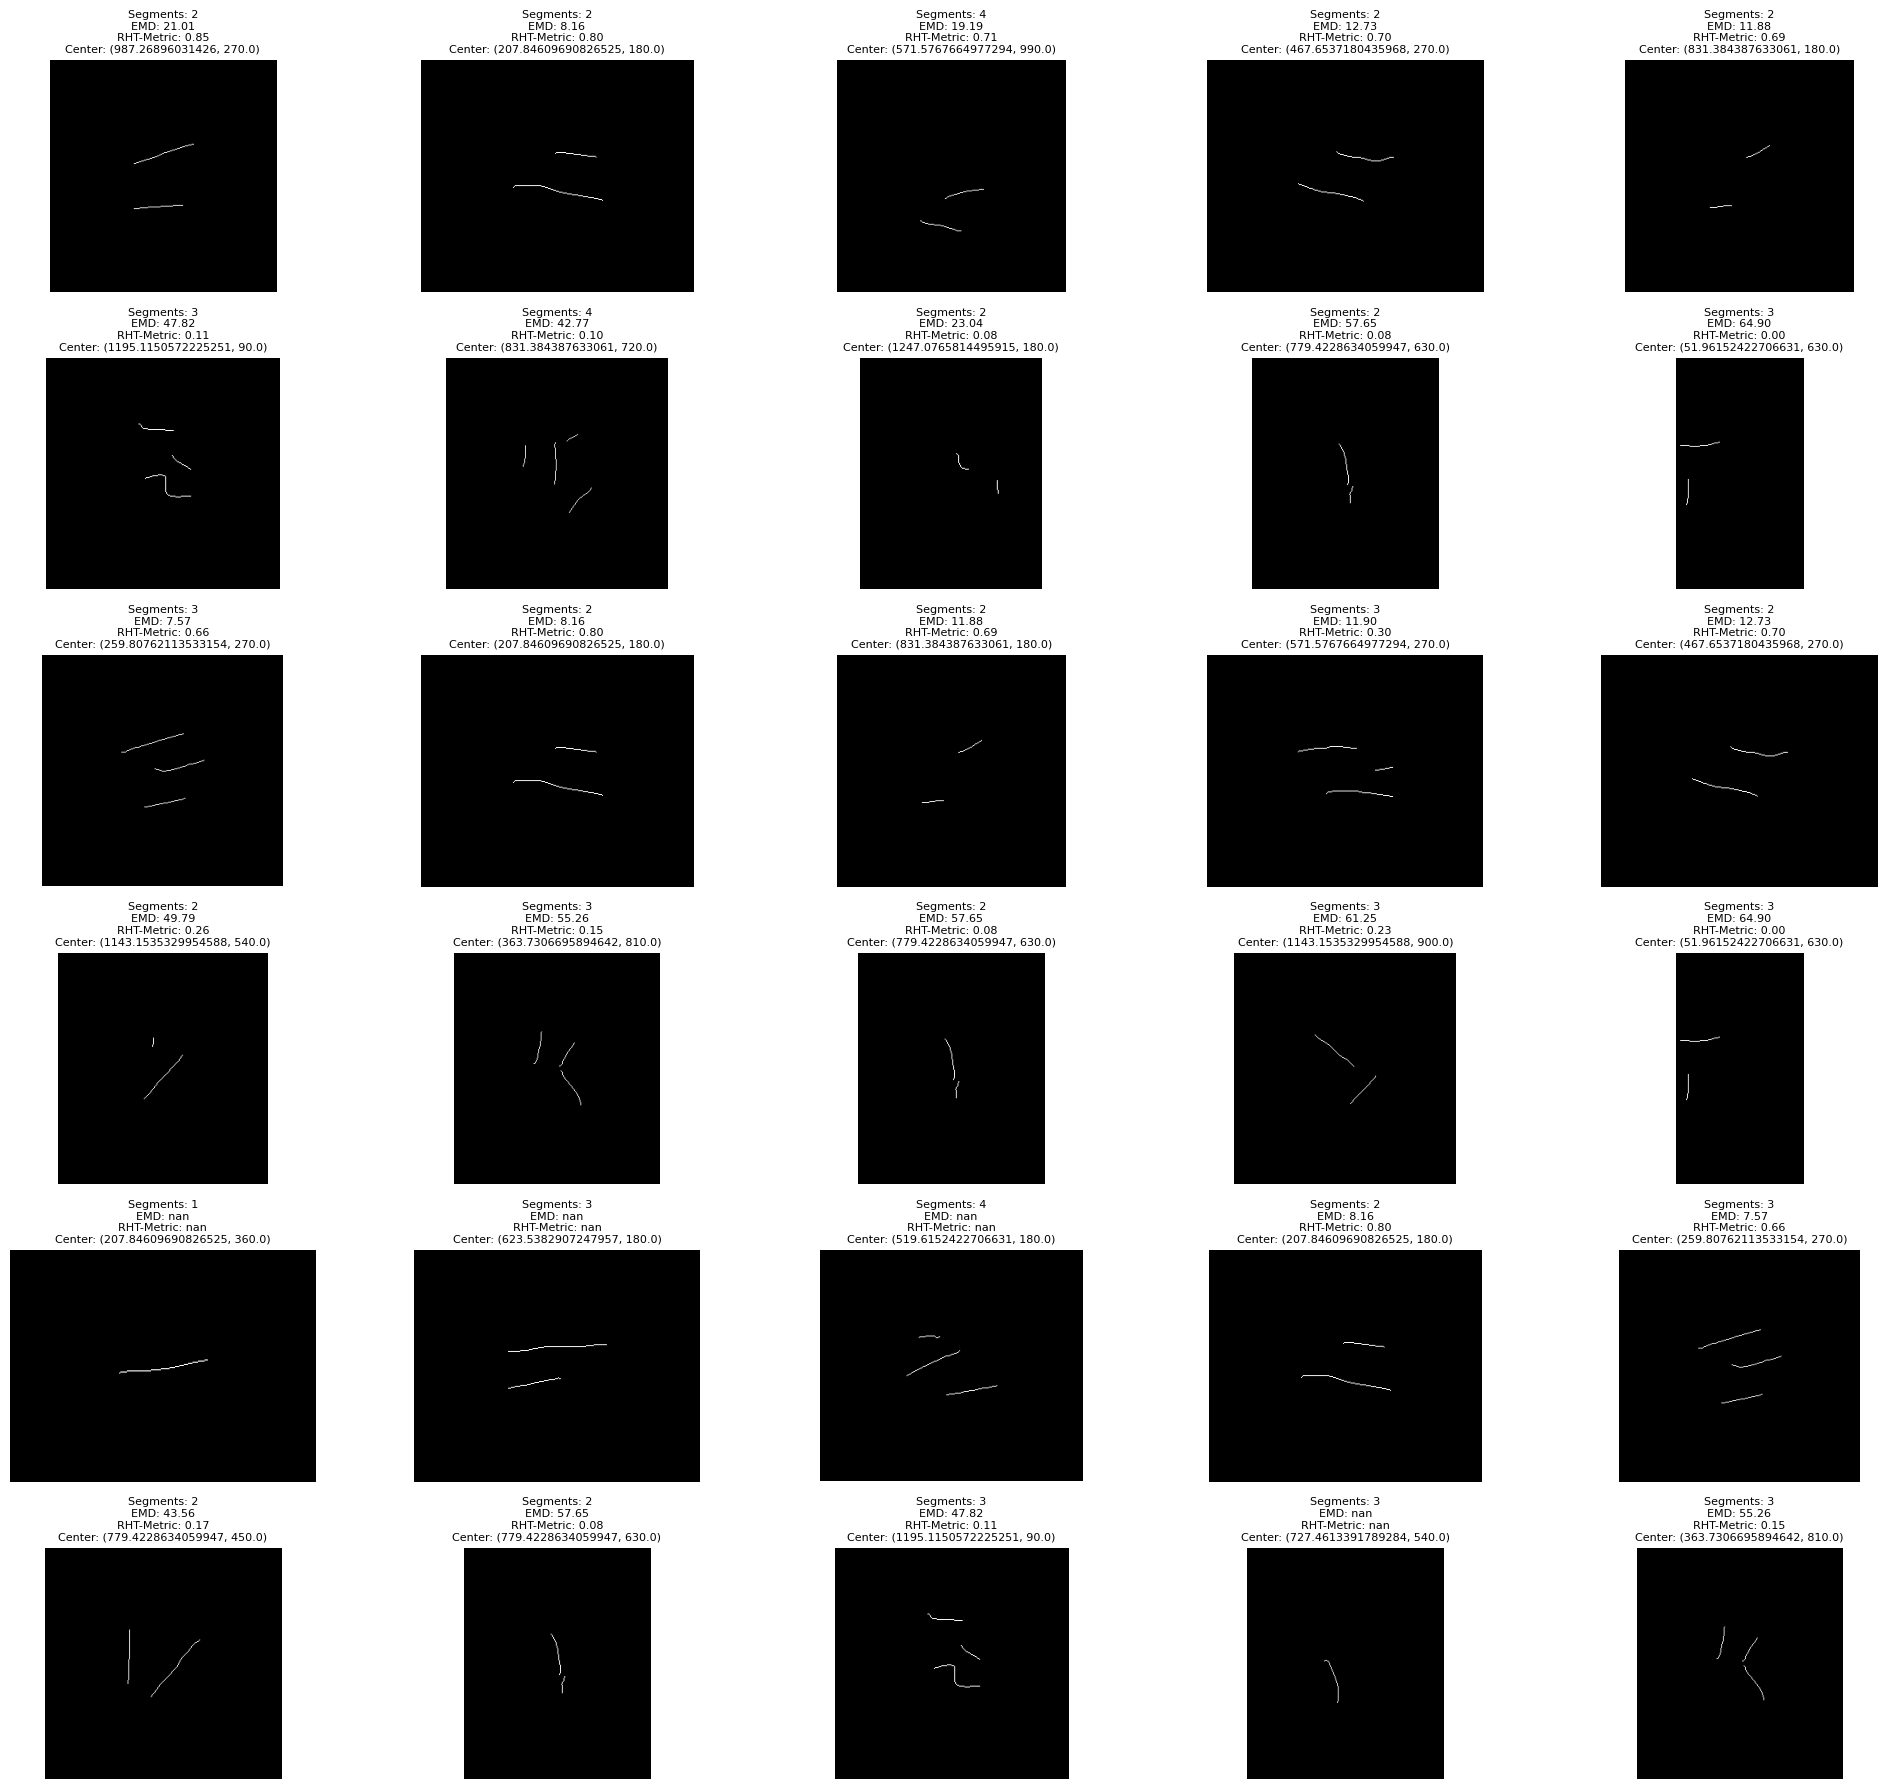

In [340]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from astropy.io import fits

fits_file = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\longestPath2.fits'

# Load the FITS file data
hdul = fits.open(fits_file)
skel = np.array(hdul[0].data)  # Assuming the image data is in the primary HDU

# Function to create a mask for a specific hexagon centered at `center`
def create_hexagon_mask(image_shape, center, corners):
    mask = myGUI.get_hexagon_mask(image_shape, corners)
    return mask

# Function to extract and zoom in on a specific hexagon region from the skel image
def extract_and_zoom_hexagon_region(skel_img, center, corners, zoom_factor=2):
    mask = create_hexagon_mask(skel_img.shape, center, corners)
    # Apply the binary mask to skel. Where mask == 255, skel values are preserved; otherwise, set to 0.
    masked_skel = np.where(mask == 255, skel, 0).astype(np.uint8)
    
    # Find bounding box of the hexagon
    y_indices, x_indices = np.where(masked_skel)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return np.zeros((256, 256), dtype=np.uint8)  # Return a blank image if no region found
    
    min_x, max_x = min(x_indices), max(x_indices)
    min_y, max_y = min(y_indices), max(y_indices)
    
    # Calculate initial crop boundaries
    crop_min_y = min_y - 100
    crop_max_y = max_y + 100
    crop_min_x = min_x - 100
    crop_max_x = max_x + 100

    # Ensure boundaries are within the image dimensions
    crop_min_y = max(crop_min_y, 0)
    crop_max_y = min(crop_max_y, skel_img.shape[0])
    crop_min_x = max(crop_min_x, 0)
    crop_max_x = min(crop_max_x, skel_img.shape[1])

    # Crop the image with adjusted boundaries
    region_cropped = masked_skel[crop_min_y:crop_max_y, crop_min_x:crop_max_x]
    labels, stats, num_labels = IA.identify_connected_components(region_cropped.astype(np.uint8))
    to_see = np.zeros_like(region_cropped)
    for segment in range(1,num_labels):
        x, y, w, h, _ = stats[segment]
        if np.sum(region_cropped[y:y+h, x:x+w])>10*255:
            to_see[y:y+h, x:x+w]+=region_cropped[y:y+h, x:x+w]
        else:
            continue

    return to_see
    return region_cropped

# Helper function to filter out items with NaN values in specific metric indices
def filter_nan_items(hex_dict, metric_index):
    return {k: v for k, v in hex_dict.items() if not np.isnan(v[metric_index])}

index = 6
# Filter hex_dict to remove items with NaN values in the metrics used for sorting
filtered_hex_dict_bin = filter_nan_items(hex_dict, index)
filtered_hex_dict_EMD = filter_nan_items(hex_dict, 0)
filtered_hex_dict_hist_bin = filter_nan_items(hex_dict, 4)

# Sort the hexagons based on metrics
sorted_by_bin_metric = sorted(filtered_hex_dict_bin.items(), key=lambda x: x[1][index], reverse=True)
sorted_by_EMD_metric = sorted(filtered_hex_dict_EMD.items(), key=lambda x: x[1][0])
sorted_by_hist_bin_metric = sorted(filtered_hex_dict_hist_bin.items(), key=lambda x: x[1][4], reverse=True)

# Extract the top 5 and bottom 5 for each metric
n = 5
top_bin_metric = sorted_by_bin_metric[:n]
bottom_bin_metric = sorted_by_bin_metric[-n:]
top_EMD_metric = sorted_by_EMD_metric[:n]
bottom_EMD_metric = sorted_by_EMD_metric[-n:]
top_hist_bin_metric = sorted_by_hist_bin_metric[:n]
bottom_hist_bin_metric = sorted_by_hist_bin_metric[-n:]

# Extract and zoom in on hexagon regions for each metric
def extract_and_zoom_regions(hex_list):
    zoomed_images = []
    titles = []
    for center, info in hex_list:
        corners = info[5]
        zoomed_image = extract_and_zoom_hexagon_region(skel, center, corners)
        
        # Extract metrics and number of segments
        EMD_metric = info[0]
        num_segments = info[2]
        hist_metric = info[6]
        
        # Format title with metrics
        title = (f"Segments: {num_segments}\n"
                 f"EMD: {EMD_metric:.2f}\n"
                 f"RHT-Metric: {hist_metric:.2f}\n"
                 f"Center: {center}")
        
        zoomed_images.append(zoomed_image)
        titles.append(title)
    
    return zoomed_images, titles

# Get zoomed-in images and titles for the top and bottom hexagons
zoomed_top_bin, titles_top_bin = extract_and_zoom_regions(top_bin_metric)
zoomed_bottom_bin, titles_bottom_bin = extract_and_zoom_regions(bottom_bin_metric)
zoomed_top_EMD, titles_top_EMD = extract_and_zoom_regions(top_EMD_metric)
zoomed_bottom_EMD, titles_bottom_EMD = extract_and_zoom_regions(bottom_EMD_metric)
zoomed_top_hist_bin, titles_top_hist_bin = extract_and_zoom_regions(top_hist_bin_metric)
zoomed_bottom_hist_bin, titles_bottom_hist_bin = extract_and_zoom_regions(bottom_hist_bin_metric)

# Display the zoomed-in hexagon regions
fig, ax = plt.subplots(6, 5, figsize=(20, 18))  # Update the grid to 6x5

# Function to display images with titles
def display_zoomed_images(ax, images, titles):
    for i, (image, title) in enumerate(zip(images, titles)):
        if i < len(ax.flat):
            ax.flat[i].imshow(image, cmap='gray')
            ax.flat[i].set_title(title, fontsize=8)
            ax.flat[i].axis('off')

# Plot images in the 6x5 grid
def plot_images(ax, images, titles, start_idx):
    for i, (image, title) in enumerate(zip(images, titles)):
        if i + start_idx < len(ax.flat):
            ax.flat[i + start_idx].imshow(image, cmap='gray')
            ax.flat[i + start_idx].set_title(title, fontsize=8)
            ax.flat[i + start_idx].axis('off')

plot_images(ax, zoomed_top_bin, titles_top_bin, 0)
plot_images(ax, zoomed_bottom_bin, titles_bottom_bin, 5)
plot_images(ax, zoomed_top_EMD, titles_top_EMD, 10)
plot_images(ax, zoomed_bottom_EMD, titles_bottom_EMD, 15)
plot_images(ax, zoomed_top_hist_bin, titles_top_hist_bin, 20)
plot_images(ax, zoomed_bottom_hist_bin, titles_bottom_hist_bin, 25)

plt.tight_layout()
plt.show()
